In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from PIL import Image, ImageDraw
from scipy import stats
from collections import defaultdict


In [108]:
def extract_ufo_data(base_dir):
    """
    UFO 형식의 JSON 파일에서 이미지 관련 정보를 추출하는 함수
    
    Returns:
        list: 각 이미지별 정보를 담은 딕셔너리의 리스트
    """
    # 결과를 저장할 리스트
    all_data = []
    
    # 언어별 처리
    languages = ['chinese', 'japanese', 'thai', 'vietnamese']
    
    for lang in languages:
        json_path = os.path.join(base_dir, f'{lang}_receipt/ufo/train.json')
        
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            # 각 이미지별 정보 추출
            for img_name, img_info in data['images'].items():
                image_data = {
                    'language': lang,
                    'image_name': img_name,
                    'img_width': img_info['img_w'],
                    'img_height': img_info['img_h'],
                    'total_words': len(img_info['words']),
                    'total_points': sum(len(word_info['points']) for word_info in img_info['words'].values()),
                    'aspect_ratio': img_info['img_w'] / img_info['img_h']
                }
                
                only_4_points = bool(image_data['total_points'] / image_data['total_words'] == 4)
                image_data['only_4_points'] = only_4_points

                all_data.append(image_data)
    
    return all_data

# 데이터 추출 및 데이터프레임으로 변환
base_dir = '../data'
data_list = extract_ufo_data(base_dir)
df = pd.DataFrame(data_list)

# 결과 확인
print(df.head())

  language                                       image_name  img_width  \
0  chinese  extractor.zh.in_house.appen_000692_page0001.jpg       1280   
1  chinese  extractor.zh.in_house.appen_000835_page0001.jpg       1280   
2  chinese  extractor.zh.in_house.appen_000849_page0001.jpg        678   
3  chinese  extractor.zh.in_house.appen_000389_page0001.jpg       3024   
4  chinese  extractor.zh.in_house.appen_000333_page0001.jpg       1418   

   img_height  total_words  total_points  aspect_ratio  only_4_points  
0        1707           34           136      0.749854           True  
1        1707           49           196      0.749854           True  
2        1240           37           148      0.546774           True  
3        4032           52           208      0.750000           True  
4        2127          197           788      0.666667           True  


1. 언어별 이미지 크기 분포 

-> 전반적으로 height가 width 비해 큰 분포를 보이고, 특히 japanese image 같은 경우 height가 1280인 크기가 많다

/tmp/ipykernel_27602/3565508298.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(mean_width, mean_height, color='green', edgecolor='black', s=100, marker='x', label=f'Mean ({mean_width:.1f}, {mean_height:.1f})')
/tmp/ipykernel_27602/3565508298.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_width, _ = stats.mode(widths)
/tmp/ipykernel_27602/3565508298.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior o

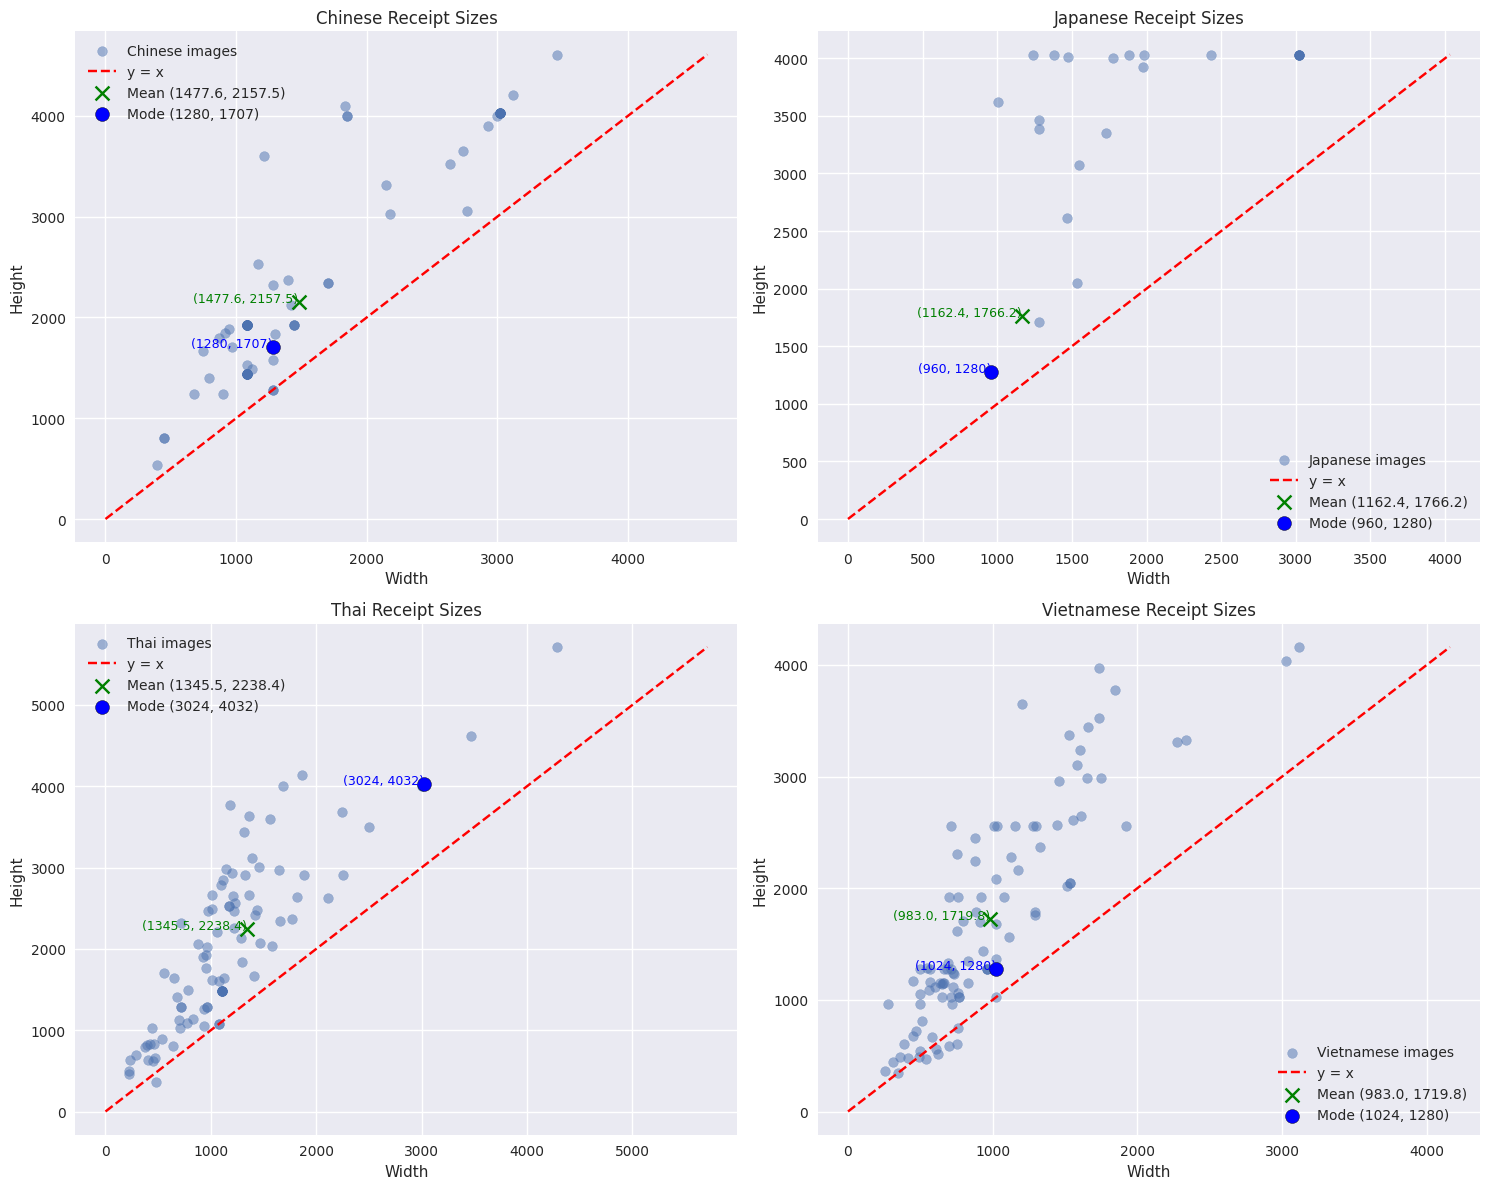

In [109]:

languages = df['language'].unique()
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, lang in enumerate(languages):
    # 현재 언어에 해당하는 데이터 필터링
    lang_data = df[df['language'] == lang]
    widths = lang_data['img_width']
    heights = lang_data['img_height']

    # 산점도 그리기
    ax = axes[i]
    ax.scatter(widths, heights, alpha=0.5, label=f'{lang.capitalize()} images')

    # y=x 선 그리기
    max_dim = max(max(widths), max(heights))
    ax.plot([0, max_dim], [0, max_dim], color='red', linestyle='--', label='y = x')

    # 평균 값 계산 및 시각화
    mean_width, mean_height = widths.mean(), heights.mean()
    ax.scatter(mean_width, mean_height, color='green', edgecolor='black', s=100, marker='x', label=f'Mean ({mean_width:.1f}, {mean_height:.1f})')

    # 모드 값 계산 및 시각화
    mode_width, _ = stats.mode(widths)
    mode_height, _ = stats.mode(heights)
    ax.scatter(mode_width, mode_height, color='blue', edgecolor='black', s=100, marker='o', label=f'Mode ({mode_width[0]}, {mode_height[0]})')

    # 각 좌표에 텍스트 추가
    ax.text(mean_width, mean_height, f'({mean_width:.1f}, {mean_height:.1f})', fontsize=9, color='green', ha='right')
    ax.text(mode_width[0], mode_height[0], f'({mode_width[0]}, {mode_height[0]})', fontsize=9, color='blue', ha='right')

    # 제목 및 레이블 설정
    ax.set_title(f'{lang.capitalize()} Receipt Sizes')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.legend()

plt.tight_layout()
plt.show()


2. 언어별 words 개수 분포 

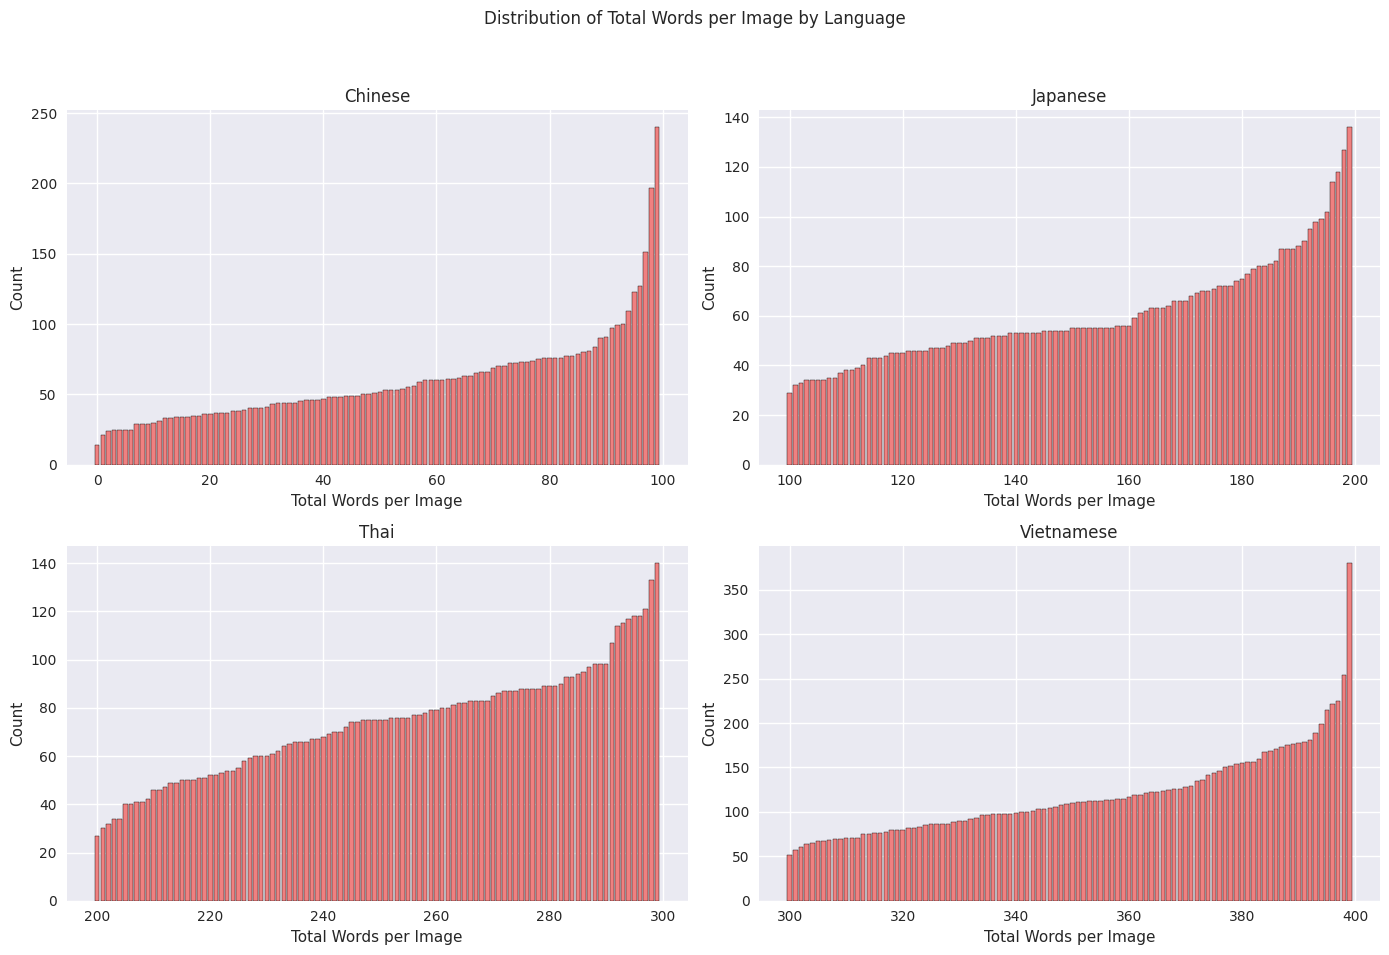

In [120]:
import matplotlib.pyplot as plt

# 언어 목록
languages = df['language'].unique()

# 서브플롯 설정
plt.figure(figsize=(14, 10))

for i, lang in enumerate(languages):
    # 현재 언어에 해당하는 데이터 필터링
    lang_data = df[df['language'] == lang]
    
    # total_words의 빈도수 계산
    word_counts = lang_data['total_words'].sort_index()
    
    # 막대그래프 그리기
    plt.subplot(2, 2, i + 1)
    plt.bar(word_counts.index, sorted(word_counts.values), color='lightcoral', edgecolor='black')
    plt.title(f'{lang.capitalize()}')
    plt.ylabel('Count')
    plt.xlabel('Total Words per Image')

plt.suptitle('Distribution of Total Words per Image by Language')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목과 서브플롯 간의 간격 조정
plt.show()


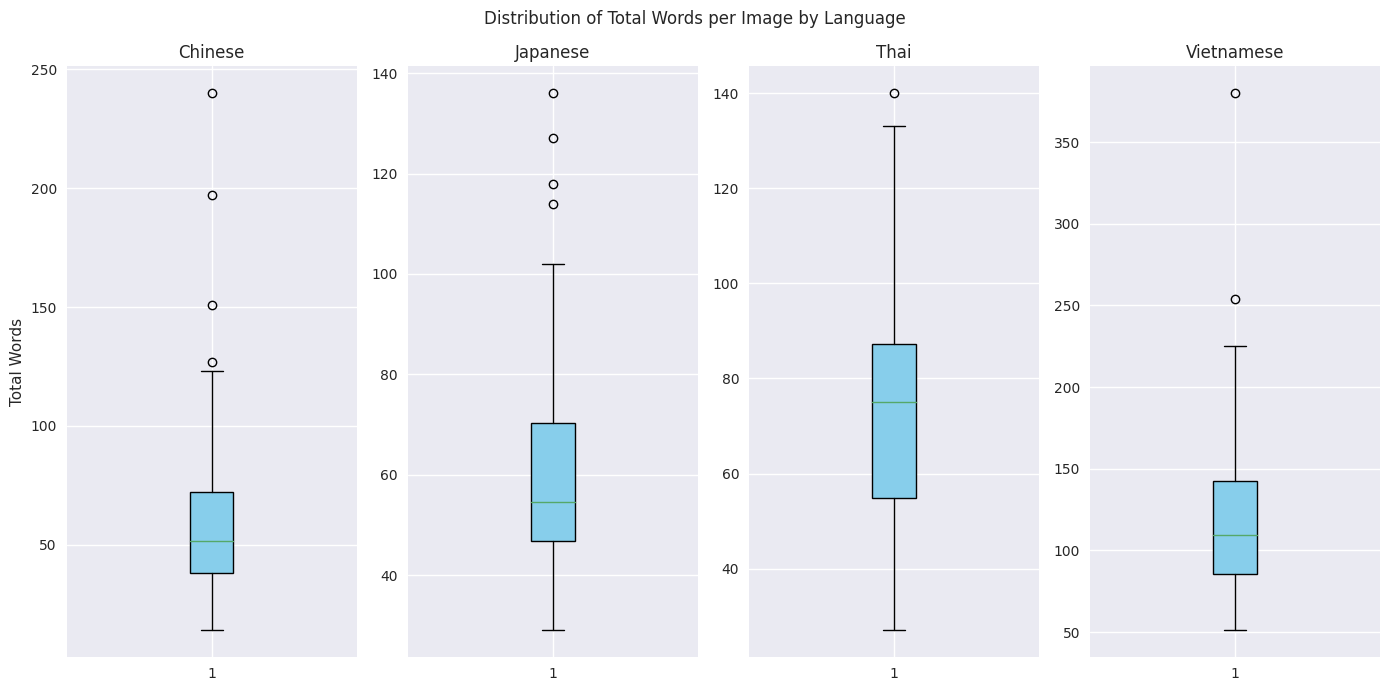

In [111]:

languages = df['language'].unique()
plt.figure(figsize=(14, 7))

for i, lang in enumerate(languages):
    # 현재 언어에 해당하는 데이터 필터링
    lang_data = df[df['language'] == lang]
    total_words = lang_data['total_words']
    
    # 각 언어의 total_words 분포를 Boxplot 형식으로 시각화
    plt.subplot(1, len(languages), i + 1)
    plt.boxplot(total_words, vert=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    plt.title(f'{lang.capitalize()}')
    plt.ylabel('Total Words' if i == 0 else '')  # 첫 번째 subplot에만 ylabel 추가
    plt.xlabel('')

plt.suptitle('Distribution of Total Words per Image by Language')
plt.tight_layout()
plt.show()


3. 언어별 words에 해당하는 points 개수

In [112]:
languages = df['language'].unique()

for i, lang in enumerate(languages):
    lang_data = df[df['language'] == lang]
    if sum(lang_data['only_4_points']) == 100:
        print(f'{lang} receipt words have only 4 points')
    else:
        print(f'{lang} receipt words have only 4 points')

chinese receipt words have only 4 points
japanese receipt words have only 4 points
thai receipt words have only 4 points
vietnamese receipt words have only 4 points


4. 언어별 points 크기 분포 

In [143]:
# 언어별 bbox 정보 담은 데이터 프레임
bbox_areas = []

for lang in languages:
    json_path = os.path.join(base_dir, f'{lang}_receipt/ufo/train.json')
    
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for img_name, img_info in data['images'].items():
        words = img_info['words']  # 각 이미지의 words 정보

        for word_info in words.values():
            points = word_info['points']
            
            # bbox 좌표는 좌상단부터 시계방향으로 되어 있음
            x_coords = [point[0] for point in points]
            y_coords = [point[1] for point in points]
            
            # bbox의 최소 및 최대 좌표 계산
            x_min = min(x_coords)
            y_min = min(y_coords)
            x_max = max(x_coords)
            y_max = max(y_coords)
            
            # 너비와 높이 계산
            width = x_max - x_min
            height = y_max - y_min
            
            # 면적 계산
            area = width * height
            
            bbox_areas.append({
                'language': lang,
                'area': area,
                'width': width,
                'height': height,
                'x_min': x_min, 
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max,
                'img_width': img_info['img_w'],
                'img_height': img_info['img_h']
            })

bbox_df = pd.DataFrame(bbox_areas)

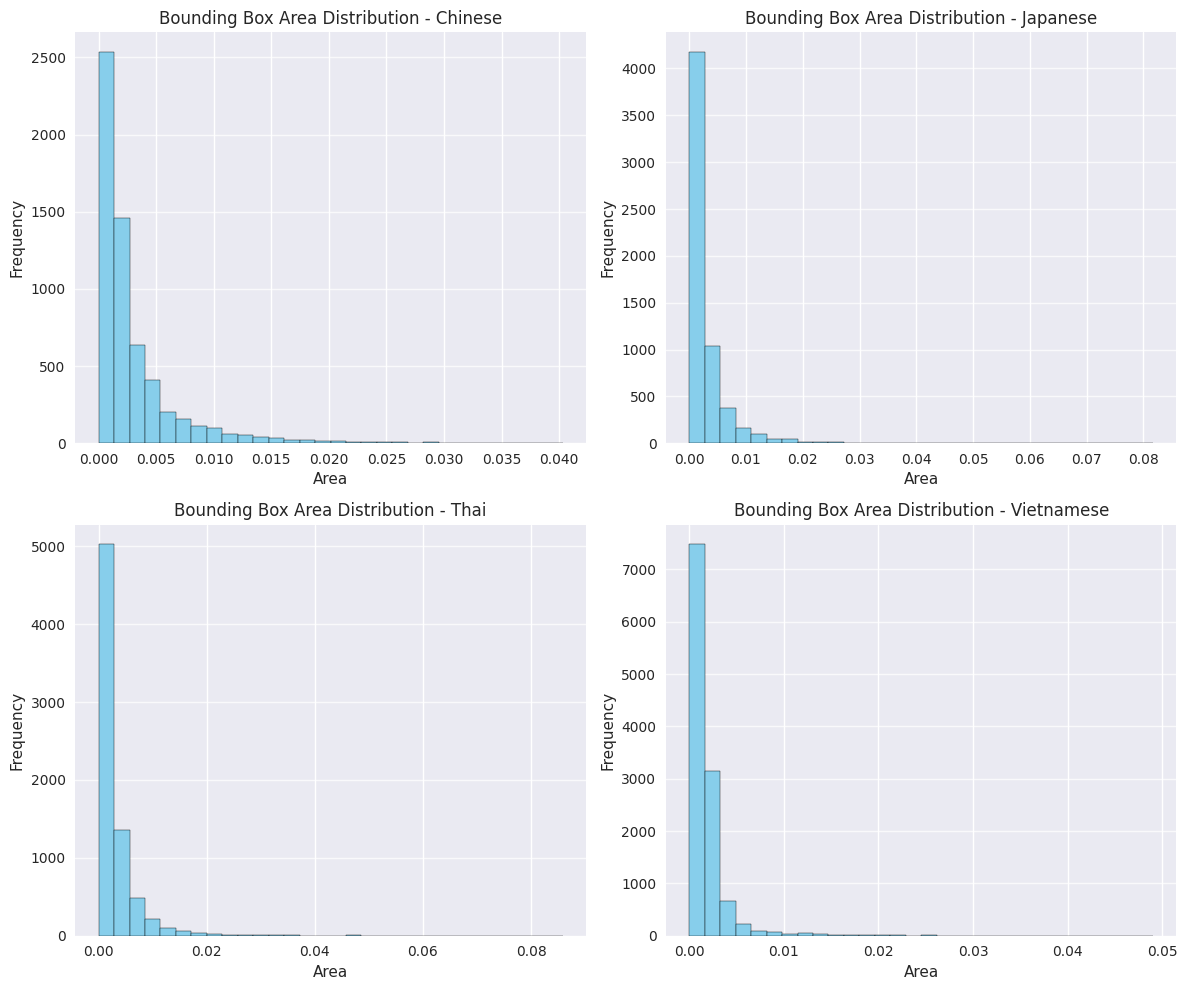

In [144]:
# 언어 목록
languages = bbox_df['language'].unique()

# 서브플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # 2x2 배열을 평탄화하여 쉽게 접근할 수 있도록

for idx, lang in enumerate(languages):
    bbox_data = bbox_df[bbox_df['language'] == lang]
    lang_areas_ratio = bbox_data['area'] / (bbox_data['img_height']*bbox_data['img_width'])

    # 히스토그램을 사용하여 면적의 빈도 분포를 시각화
    axes[idx].hist(lang_areas_ratio, bins=30, color='skyblue', edgecolor='black')
    
    axes[idx].set_title(f'Bounding Box Area Distribution - {lang.capitalize()}')
    axes[idx].set_xlabel('Area')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


5. 언어별 bbox 종횡비 분포

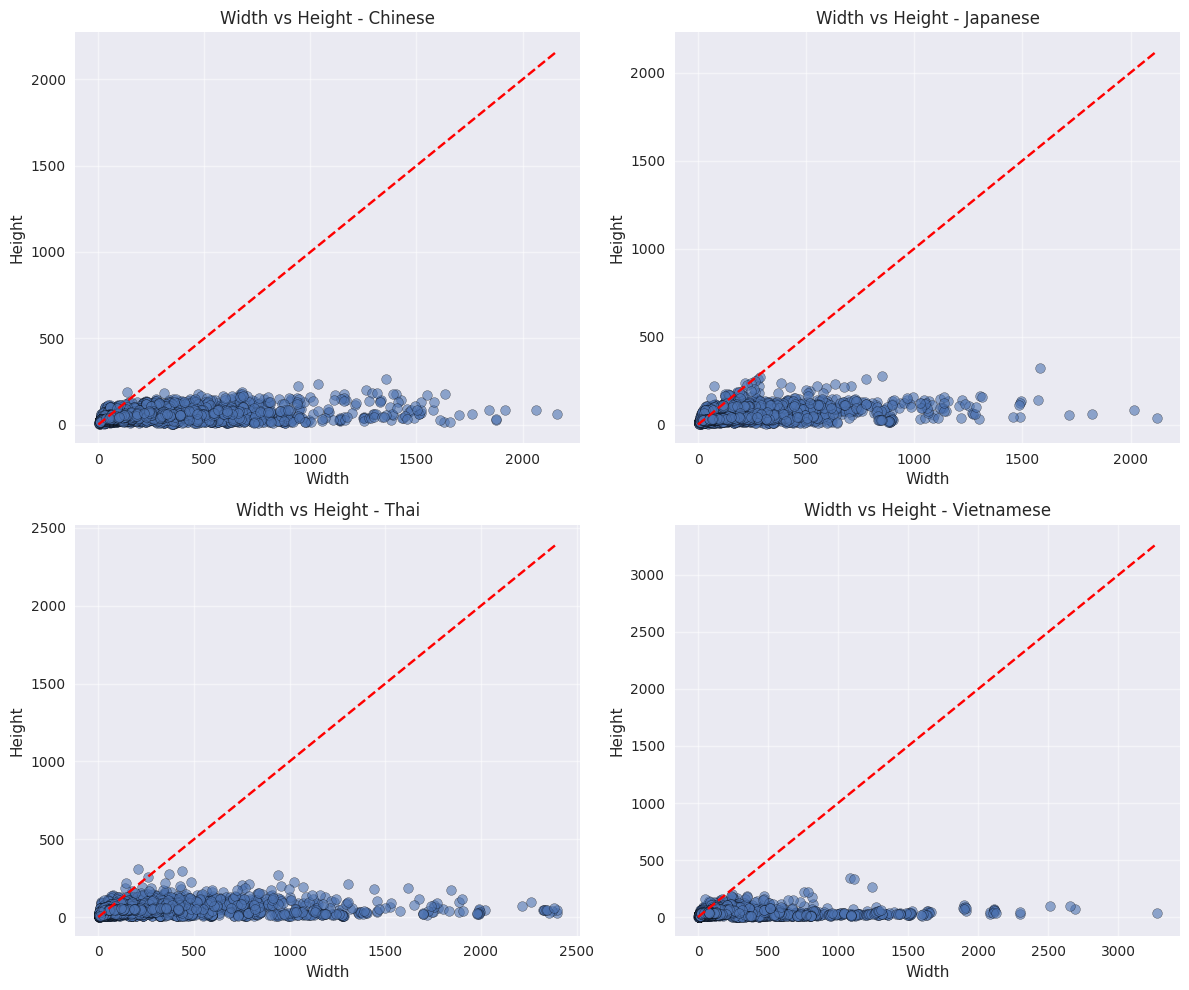

In [122]:
# 언어 목록
languages = bbox_df['language'].unique()

# 서브플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # 2x2 배열을 평탄화하여 쉽게 접근할 수 있도록

for idx, lang in enumerate(languages):
    lang_data = bbox_df[bbox_df['language'] == lang]

    # 산점도 그리기
    axes[idx].scatter(lang_data['width'], lang_data['height'], alpha=0.6, edgecolor='black')
    
    axes[idx].set_title(f'Width vs Height - {lang.capitalize()}')
    axes[idx].set_xlabel('Width')
    axes[idx].set_ylabel('Height')
    axes[idx].grid(alpha=0.5)

    max_dim = max(max(lang_data['width']), max(lang_data['height']))
    axes[idx].plot([0, max_dim], [0, max_dim], color='red', linestyle='--', label='y = x')

plt.tight_layout()
plt.show()

6. 언어별 이미지 내에 bbox 위치하는 분포

100%|██████████| 31162/31162 [00:00<00:00, 91449.30it/s]


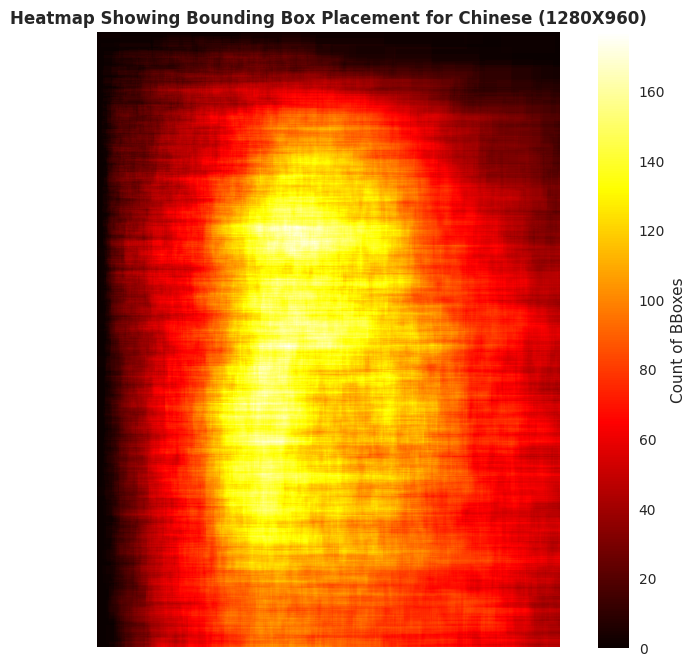

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from tqdm import tqdm

# 특정 언어와 이미지 크기 필터링 조건 설정
target_lang = 'chinese'  # 특정 언어를 지정 (예: 'chinese')
target_size = (1280, 960)  # 필터링할 이미지 크기

# 히트맵 크기 설정
img_height, img_width = target_size
HEATMAP_SIZE = (img_height, img_width)

# 언어별 bbox 데이터 필터링
filtered_data = df[(df['language'] == target_lang) &
                   (df['img_height'] == target_size[0]) & 
                   (df['img_width'] == target_size[1])]

# 히트맵 초기화
heatmap = np.zeros(HEATMAP_SIZE, dtype=np.int16)

# bbox numpy 배열로 변환
bbox_np = bbox_df[["x_min", "x_max", "y_min", "y_max"]].to_numpy()
bbox_np = np.floor(bbox_np).astype(np.int16)  # 좌표값을 정수로 변환

# 히트맵 누적 계산
for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[2]:row[3]+1, row[0]:row[1]+1] += 1

# 히트맵 시각화
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.title(f"Heatmap Showing Bounding Box Placement for {target_lang.capitalize()} (1280X960)", fontweight="bold")
plt.colorbar(label="Count of BBoxes")
plt.axis(False)
plt.show()

In [135]:
bbox_df.groupby('language').count()

,area,width,height,x_min,y_min,x_max,y_max
language,,,,,,,
chinese,5931,5931,5931,5931,5931,5931,5931
japanese,6028,6028,6028,6028,6028,6028,6028
thai,7344,7344,7344,7344,7344,7344,7344
vietnamese,11859,11859,11859,11859,11859,11859,11859
